Étape 2 : Commencer l'analyse dans le Notebook

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pour afficher les graphiques directement dans le notebook
%matplotlib inline


In [6]:
# Chargement du dataset (le chemin remonte d'un dossier puis va dans data)
df = pd.read_csv('../data/dirty_cafe_sales.csv')

# Affichage des 5 premières lignes
print("--- Aperçu des données ---")
display(df.head())

# Informations techniques (colonnes, types, valeurs non-nulles)
print("\n--- Informations sur le dataset ---")
df.info()

--- Aperçu des données ---


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11



--- Informations sur le dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


Étape 3 : Identifier les problèmes

In [7]:
# 1. Vérification des valeurs manquantes
print("--- Valeurs manquantes ---")
print(df.isnull().sum())

# 2. Vérification des doublons
print(f"\nNombre de lignes en double : {df.duplicated().sum()}")

# 3. Vérification des types de données
print("\n--- Types des colonnes ---")
print(df.dtypes)

# 4. Aperçu des valeurs uniques pour détecter des incohérences (ex: fautes de frappe)
print("\n--- Éléments vendus (Items) ---")
print(df['Item'].unique())

--- Valeurs manquantes ---
Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

Nombre de lignes en double : 0

--- Types des colonnes ---
Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object

--- Éléments vendus (Items) ---
['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'UNKNOWN' 'Sandwich' nan
 'ERROR' 'Juice' 'Tea']


: Conversion des types (Le plus urgent)

In [8]:
# Conversion des colonnes numériques
# 'errors=coerce' transformera les textes invalides en NaN (valeurs vides)
cols_numeriques = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in cols_numeriques:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Conversion de la date
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

print("Nouveaux types de colonnes :")
print(df.dtypes)

Nouveaux types de colonnes :
Transaction ID              object
Item                        object
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method              object
Location                    object
Transaction Date    datetime64[ns]
dtype: object


: Gérer les valeurs manquantes
Nous devons prendre des décisions "métier" :

Item / Price / Quantity : Si l'une de ces trois données manque, la ligne est difficilement utilisable pour un calcul de chiffre d'affaires.

Payment Method / Location : Il y en a trop de vides pour tout supprimer. On va les remplacer par "Unknown" (Inconnu).

In [9]:
# 1. Remplacer les catégories manquantes par 'Unknown'
df['Payment Method'] = df['Payment Method'].fillna('Unknown')
df['Location'] = df['Location'].fillna('Unknown')

# 2. Supprimer les lignes où l'Item est inconnu (on ne sait pas ce qu'on a vendu)
df = df.dropna(subset=['Item'])

# 3. Pour le prix ou la quantité, on pourrait imputer (remplacer par la moyenne) 
# mais ici, on va supprimer les lignes vides pour avoir une donnée très propre.
df = df.dropna(subset=['Quantity', 'Price Per Unit'])

print(f"Nombre de lignes restantes après nettoyage : {len(df)}")

Nombre de lignes restantes après nettoyage : 8713


Étape 3 : Standardiser le texte
Pour éviter d'avoir "Coffee" et "coffee" comptés séparément.


In [10]:
# Nettoyage de la colonne Item
df['Item'] = df['Item'].str.strip().str.capitalize()

print("Liste des produits unique après nettoyage :")
print(df['Item'].unique())

Liste des produits unique après nettoyage :
['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'Unknown' 'Sandwich' 'Error'
 'Juice' 'Tea']


Étape 4 : Transformer les données (Feature Engineering)
Dans cette étape, nous allons faire trois choses :


In [11]:
# 1. Recalculer le Total pour vérifier la cohérence
df['Total_Spent_Calculated'] = df['Quantity'] * df['Price Per Unit']

# 2. Extraire des informations temporelles
# On extrait le mois, le jour de la semaine et l'heure
df['Month'] = df['Transaction Date'].dt.month_name()
df['Day_of_Week'] = df['Transaction Date'].dt.day_name()
df['Hour'] = df['Transaction Date'].dt.hour

# 3. Créer une catégorie "Moment de la journée"
def get_period(hour):
    if 6 <= hour < 12:
        return 'Matin'
    elif 12 <= hour < 18:
        return 'Après-midi'
    else:
        return 'Soir'

df['Period'] = df['Hour'].apply(get_period)

print("--- Nouvelles colonnes créées ---")
display(df[['Transaction Date', 'Item', 'Quantity', 'Total_Spent_Calculated', 'Day_of_Week', 'Period']].head())

--- Nouvelles colonnes créées ---


,Transaction Date,Item,Quantity,Total_Spent_Calculated,Day_of_Week,Period
0,2023-09-08,Coffee,2.0,4.0,Friday,Soir
1,2023-05-16,Cake,4.0,12.0,Tuesday,Soir
2,2023-07-19,Cookie,4.0,4.0,Wednesday,Soir
3,2023-04-27,Salad,2.0,10.0,Thursday,Soir
4,2023-06-11,Coffee,2.0,4.0,Sunday,Soir


Étape 5 : Vérification de la qualité finale


In [12]:
print("--- Check Final ---")
# Vérifier s'il reste des valeurs nulles
print(f"Valeurs nulles restantes : {df.isnull().sum().sum()}")

# Vérifier la cohérence des prix (pas de prix négatifs par exemple)
print(f"Prix minimum : {df['Price Per Unit'].min()}")

# Aperçu final du dataset propre
df.to_csv('../data/cleaned_cafe_sales.csv', index=False)
print("\nFichier 'cleaned_cafe_sales.csv' sauvegardé dans le dossier data !")

--- Check Final ---
Valeurs nulles restantes : 2024
Prix minimum : 1.0

Fichier 'cleaned_cafe_sales.csv' sauvegardé dans le dossier data !


Étape 1 : Créer les visualisations

C:\Users\ethan\AppData\Local\Temp\ipykernel_29148\244061010.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


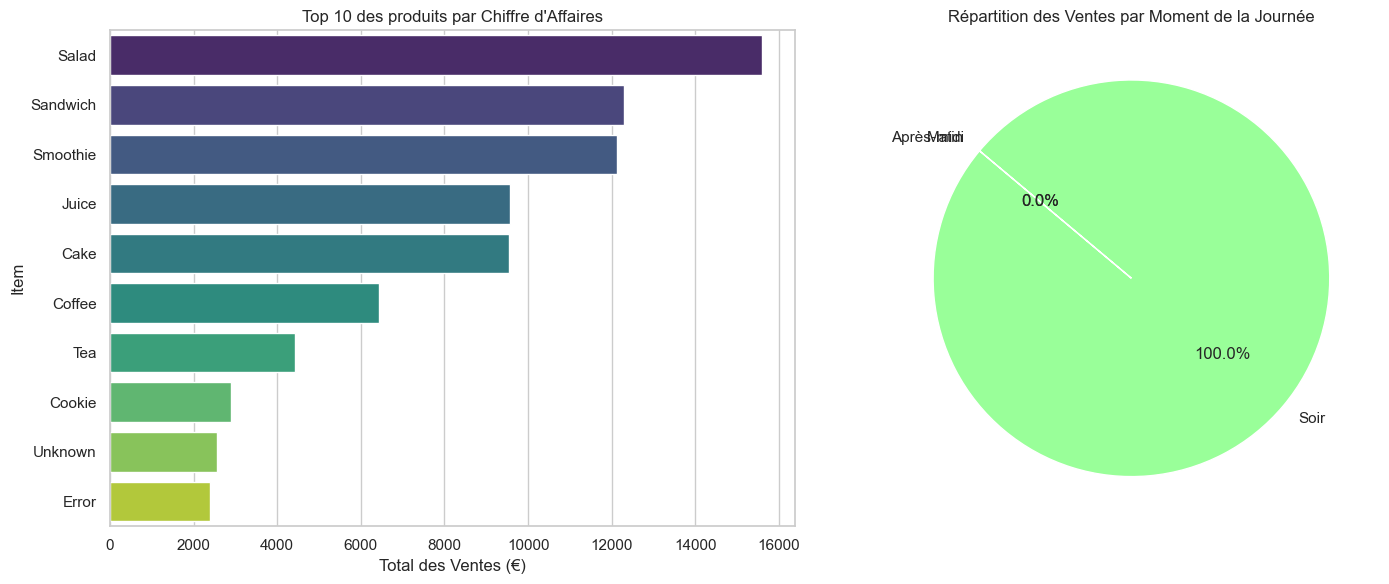

In [15]:
# Configuration du style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# --- Graphique 1 : Top 10 des produits ---
plt.subplot(1, 2, 1)
# On s'assure de grouper et de supprimer les éventuels produits vides
top_products = df.groupby('Item')['Total_Spent_Calculated'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 des produits par Chiffre d\'Affaires')
plt.xlabel('Total des Ventes (€)')

# --- Graphique 2 : Ventes par moment (CORRIGÉ) ---
plt.subplot(1, 2, 2)
# .fillna(0) remplace les catégories sans ventes par 0 pour éviter l'erreur NaN
sales_by_period = df.groupby('Period')['Total_Spent_Calculated'].sum().reindex(['Matin', 'Après-midi', 'Soir']).fillna(0)

# On vérifie si on a des données à afficher pour éviter une erreur de concaténation
if sales_by_period.sum() > 0:
    plt.pie(sales_by_period, labels=sales_by_period.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title('Répartition des Ventes par Moment de la Journée')
else:
    plt.text(0.5, 0.5, "Aucune donnée de période disponible", ha='center')

plt.tight_layout()
plt.show()

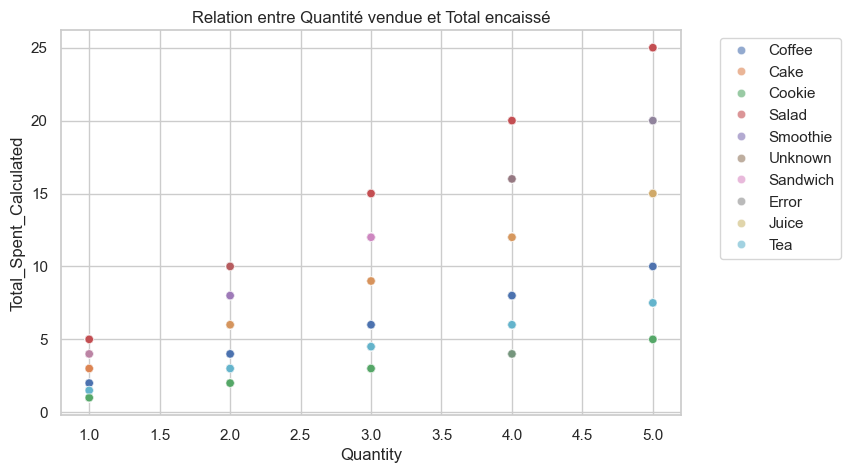

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Quantity', y='Total_Spent_Calculated', hue='Item', alpha=0.6)

plt.title('Relation entre Quantité vendue et Total encaissé')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()